# Convolutional Neural Networks
---
In this notebook, let's train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

### Using GPU instead of CPU  [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up the training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

# on my Mac CUDA is unavailable. Let's check it with the lines below
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available. Training on GPU...')
else:
    print('CUDA is not available :( Training on CPU...')


CUDA is not available :( Training on CPU...


### Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# lets set number of workers (=subprocesses) to for data loading. 
# BTW. each worker loads the entire batch and returns it when finished. 
# Some say that number of workers should be calculated as : num_workers = 4 * GPU's
# I do not have GPU so lets set it to 0
num_workers = 0

# lets et the batch size. how many img samples per batch to load
batch_size = 20

# lets set the percentage for training set as follows: 80% training and 20% validation
validation_size = 0.2

# lets set the transform to convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(), #setst the values in range [0, 255] into range [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #setst the values in range [0, 1] into range [-1, 1]
])

# lets set the training and testing sets
train_set = datasets.CIFAR10('data', train = True, download = True, transform = transform)
test_set = datasets.CIFAR10('data', train = False, download = True, transform = transform)

print('train_set', train_set)
print('test_set', test_set)


Files already downloaded and verified
train_set Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None
test_set Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


In [13]:
# lets get training indices that will be used for validation
num_train = len(train_set) #gives number of 50.000
indices = list(range(num_train)) #gives list of int from 0 to 49.999
np.random.shuffle(indices) # gives randomly shuffeled list
#split = int(np.floor(validation_size * num_train))
split = int(np.floor(validation_size * num_train)) # gives 10.000
train_idx = indices[split:] #seting training set from 10000 till 49.999. those are indexes in list
validation_idx = indices[:split] #setting validation set from 0 till 9.999. those are indexes in list

# lets set the training samplers
train_sampler = SubsetRandomSampler(train_idx) # len(train_sampler) = 40.000

# lets set the validation samplers
validation_sampler = SubsetRandomSampler(validation_idx) #len(validation_sampler) = 10.000

# lets prepare data loaders
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size = batch_size, 
                                           sampler = train_sampler,
                                          num_workers = num_workers) #len 2000 = train_sampler / batch_size

validation_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size = batch_size, 
                                           sampler = validation_sampler,
                                          num_workers = num_workers) #len 500 = validation_sampler / batch_size

test_loader = torch.utils.data.DataLoader(test_set, 
                                           batch_size = batch_size, 
                                          num_workers = num_workers) #len 500 train_set / batch_size

# lets define the images classes names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


In [14]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
validation_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(validation_size * num_train))
train_idx, validation_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers) 
validation_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=validation_sampler, num_workers=num_workers) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers) 

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']



Files already downloaded and verified
Files already downloaded and verified


### Visualize a Batch of Training Data

This part of code is copied from Udacity

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

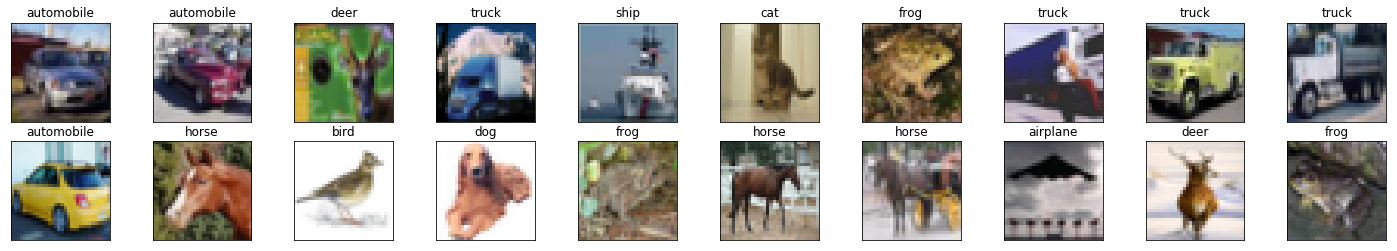

In [16]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail
This part of code is copied from Udacity

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

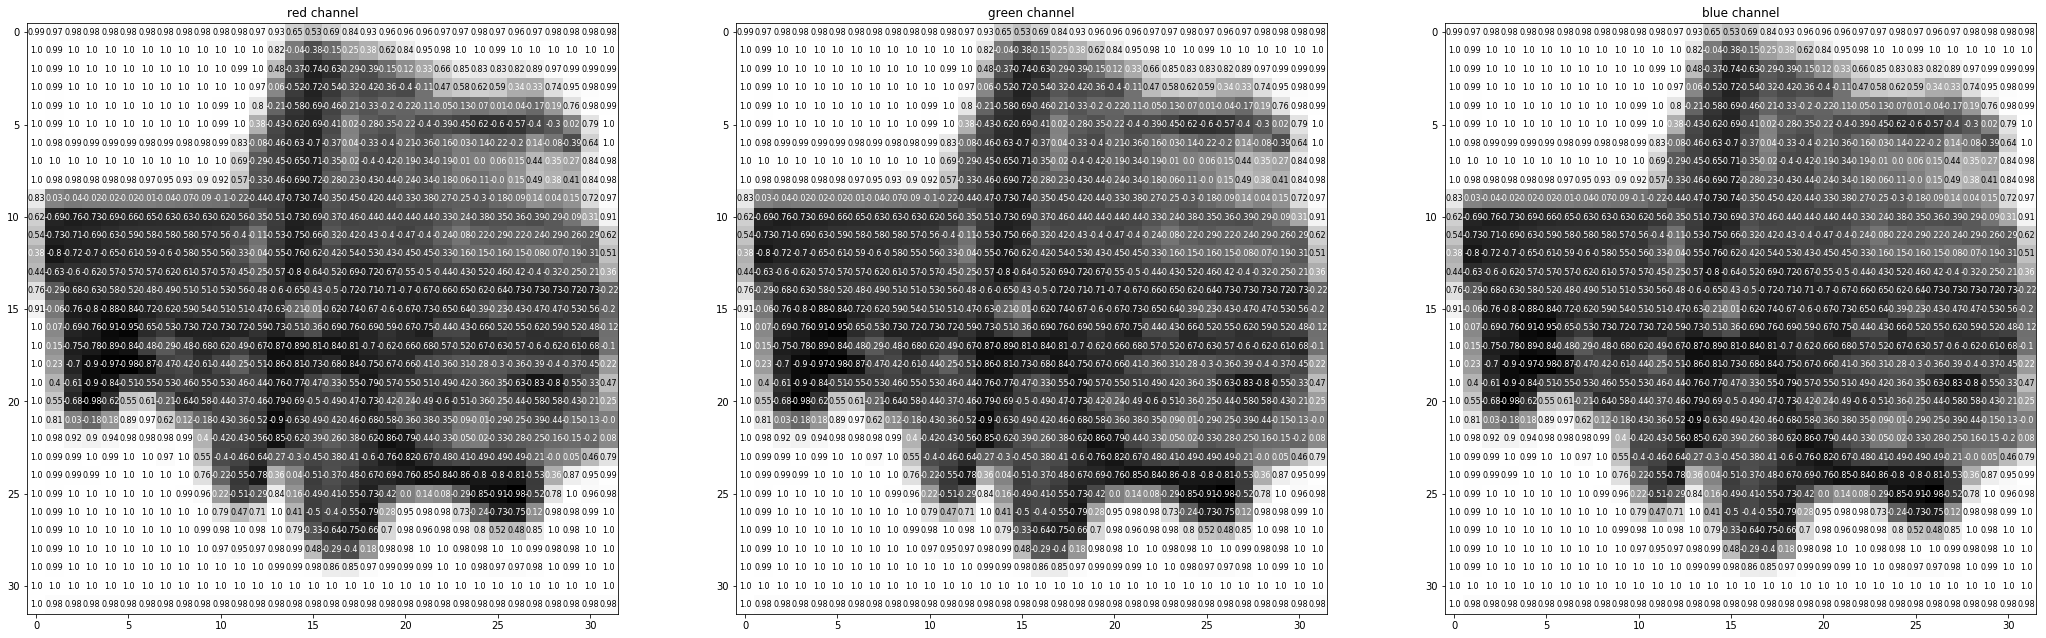

In [8]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

### Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)


<img src='notebook_ims/2_layer_conv.png' height=50% width=50% />


#### Output volume for a convolutional layer

`(W−F+2P)/S+1`. 

Example 1 : for a 7x7 input and a 3x3 filter (one filter) with stride 1 and pad 0:
(7 - 3 + 2*0)/1 + 1 = 4 / 1 + 1 = 4 + 1  = 5 so we would get a 5x5 output. 

Example 2 : for a 7x7 input and a 3x3 filter (one filter) with stride 2 and pad 0:
(7 - 3 + 2*0)/2 + 1 = 4 / 2 + 1 = 2 + 1  = 3 so we would get a 3x3 output. 

In [18]:
import torch.nn as nn
import torch.nn.functional as F

# lets define the CNN network architecture below
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # convolutional layers 
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1) #sees input 32 x 32 x 3 (=depth, because of 3 RGB color chanels), output depth = 16, and 3 filters 3x3 in size
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1) #sees input 16 x 16 x depth = 16, output depth = 32, and 3 filters 3x3 in size) 
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)  # sees input 8 x 8 x depth = 32, output depth = 64, and 3 filters 3x3 in size) 
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2) # it will reduce the x and y dimentions by 2 each time it's used
        
        # liner layers in MLP network
        self.fc1 = nn.Linear(64 * 4 * 4, 500) # 64 id a depth of conv3 output, 4 x 4 is x and y size of layer after 3rt pool method which decrease size by 2 each time (which is: 32 / 2 = 16 / 2 = 8 / 2 = 4. 500 is a number of outputs which will be inputs in the next linear layer
        self.fc2 = nn.Linear(500, 10) # 10 class scores as output
        
        # define dropout
        self.dropout = nn.Dropout(0.25) #dropout 25% to prevent overfitting

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 *4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        return x

# create a complete CNN
model = CNN()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

list of loss functions and optimizers in linkS above.

In [19]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.03)

### Train the Network

Because my Mac doesn't have GPU I used cloud GPU (FloydHub) to train my network.

In [21]:
# number of epochs to train the model
n_epochs = 1 # you may change this number to train a model

validation_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    validation_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in validation_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        validation_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    validation_loss = valid_loss/len(validation_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, validation_loss))
    
    # save model if validation loss has decreased
    if validation_loss <= validation_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        validation_loss_min,
        validation_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        validation_loss_min = validation_loss

Epoch: 1 	Training Loss: 1.141481 	Validation Loss: 0.000000
Validation loss decreased (inf --> 0.000000).  Saving model ...


###  Load the Model with the Lowest Validation Loss

In [22]:
model.load_state_dict(torch.load('model_cifar.pt'))


### Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70%.

In [23]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.274718

Test Accuracy of airplane: 67% (672/1000)
Test Accuracy of automobile: 80% (808/1000)
Test Accuracy of  bird: 34% (341/1000)
Test Accuracy of   cat: 23% (237/1000)
Test Accuracy of  deer: 38% (387/1000)
Test Accuracy of   dog: 41% (416/1000)
Test Accuracy of  frog: 73% (739/1000)
Test Accuracy of horse: 74% (748/1000)
Test Accuracy of  ship: 37% (378/1000)
Test Accuracy of truck: 66% (668/1000)

Test Accuracy (Overall): 53% (5394/10000)


### Visualize Sample Test Results
This part of code was taken from Udacity

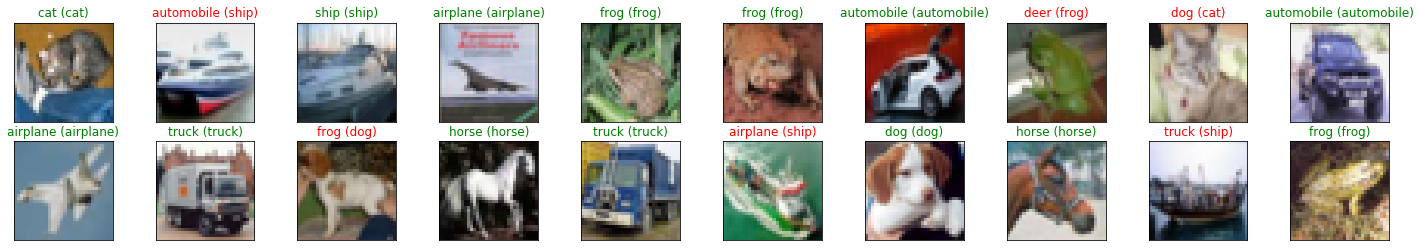

In [24]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))